In [1]:
import sys
# for local development
RT_LIBS_PATH = "/Users/alex/Dev_projects/MyOwnRepo/rt_libs/src"
BA_LIBS_PATH = "/Users/alex/Dev_projects/MyOwnRepo/basic_application/src"
sys.path.append(RT_LIBS_PATH)
sys.path.append(BA_LIBS_PATH)

In [2]:
%matplotlib notebook
db_connect_params = {
    "host" : "194.87.210.189",
    "port" : 59000,
    "user" : "alex",
    "password" : "Xrxcmr758",
    "database" : "rt5"
}

In [3]:
import time
import cProfile, pstats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from data_providers import DbDataProviderRT5
from data_providers import ClickHouseConnector

from core.context import BasicContext
from data_point import DataPoint, DataPointFactory
from core.action_controller import ActionControllerDiffReward

from core.observation_builder.precompute import PrecomputeOrderbookDiffFeature

from core.observation_builder.features2 import RatesFeature2D

## Dataset

In [5]:
path_train = "/Users/alex/Dev_projects/RT/model_train/datasets/rt5/03.BTC_USDT-300-train.csv"
path_test = "/Users/alex/Dev_projects/RT/model_train/datasets/rt5/03.BTC_USDT-300-test.csv"
path_test2 = "/Users/alex/Dev_projects/RT/model_train/datasets/rt5/03.BTC_USDT-300-test2.csv"

data_train = pd.read_csv(path_train, index_col='ts')
data_test = pd.read_csv(path_test, index_col='ts')
data_test2 = pd.read_csv(path_test2, index_col='ts')

In [6]:
try:
    dataset = pd.read_csv("./test_dataset.csv", index_col='ts')
    print("Прочитано из файла")
except FileNotFoundError:
    
    ts = int(time.time())
    period = 60
    total_points = 5000

    pair = "BTC_USDT"


    #----
    with ClickHouseConnector(db_connect_params) as conn:
        data_provider = DbDataProviderRT5(conn)

        dataset = data_provider.get(
                                ts,
                                period,
                                total_points,
                                pair
                            )
    dataset.to_csv("./test_dataset.csv")
    print("Загружен новый датасет")
    
print(dataset.shape)

Прочитано из файла
(5000, 11)


In [7]:
dataset.index.values

array([1675190531, 1675190591, 1675190651, ..., 1675490351, 1675490411,
       1675490471])

In [8]:
dataset = data_train

# Context

In [9]:
dpf = DataPointFactory(dataset, step_size=1, offset=50, observation_len=10, future_points=0)
dp = dpf.get_current_step()
context = BasicContext()
context.update_datapoint(dp)

# Feature

In [10]:
"""
Module with basic features - deal status, rate, profit.
"""

import logging
import numpy as np
import pandas as pd

from core.observation_builder.features2.abstract_feature import AbstractFeature

logger = logging.getLogger(__name__)


class RatesFeature2D(AbstractFeature):
    """Returns a matrix with normalized rates for different periods"""

    def __init__(self, context, step_factor=(1,), scale_output=30):
        super().__init__(context, step_factor=step_factor, scale_output=scale_output)

    def _get(self):
        data_point = self.context.data_point
        current_price = data_point.get_value("highest_bid")
        current_price = current_price[0]
        obs = []
        for sf in self.step_factor:
            feature = data_point.get_values("highest_bid", step_factor=sf, num=data_point.observation_len+1)
            feature = np.diff(feature)
            feature = (feature / current_price) * self.scale_output

            if sf > 1:
                res = []
                for i in range(data_point.observation_len):
                    val = feature[sf * i: sf * (i + 1)]
                    res.append(val.mean())
                feature = np.array(res).reshape(-1, 1)
            else:
                feature = feature.reshape(-1, 1)
            obs.append(feature)
        feature = np.concatenate([*obs], axis=1)
        return feature

# Perfomance test

In [11]:
def perfomance_test(dataset):
    dpf = DataPointFactory(dataset, step_size=1, offset=150, observation_len=30, future_points=0)
    dp = dpf.reset()
    done = False
    scale_factor = (1,3,5)
    
    feature = RatesFeature2D(context, step_factor=scale_factor, scale_factor=1)

    while not done:
        dp, done = dpf.get_next_step()
        obs = feature.get()
        
#cProfile.run("perfomance_test(dataset)")

In [12]:
profiler = cProfile.Profile()
profiler.enable()

perfomance_test(data_test2)

profiler.disable()

TypeError: __init__() got an unexpected keyword argument 'scale_factor'

In [ ]:
stats = pstats.Stats(profiler).sort_stats('tottime')
stats.print_stats()

# Оценка распределения

In [18]:
dataset = data_test

done = False

dpf = DataPointFactory(dataset, step_size=1, offset=360, observation_len=30, future_points=0)
context = BasicContext()
step_factor = (1,3,6)
feature = RatesFeature2D(context, step_factor=step_factor, scale_output=120)

dp = dpf.get_current_step()
context.update_datapoint(dp)
    
action_controller = ActionControllerDiffReward(context)

results = {}



while not done:
    dp, done = dpf.get_next_step()
    context.update_datapoint(dp)
    
    
    trade_is_open = context.get("is_open", domain="Trade")

    obs = feature.get(clip_edge=3)

    for sf_id in range(len(step_factor)):
        values = obs[:, sf_id]

        key_sf = f"sf-{step_factor[sf_id]}"
        if key_sf not in results:
            results[key_sf] = values
        else:
            results[key_sf] = np.concatenate([results[key_sf], values])
        

<IPython.core.display.Javascript object>


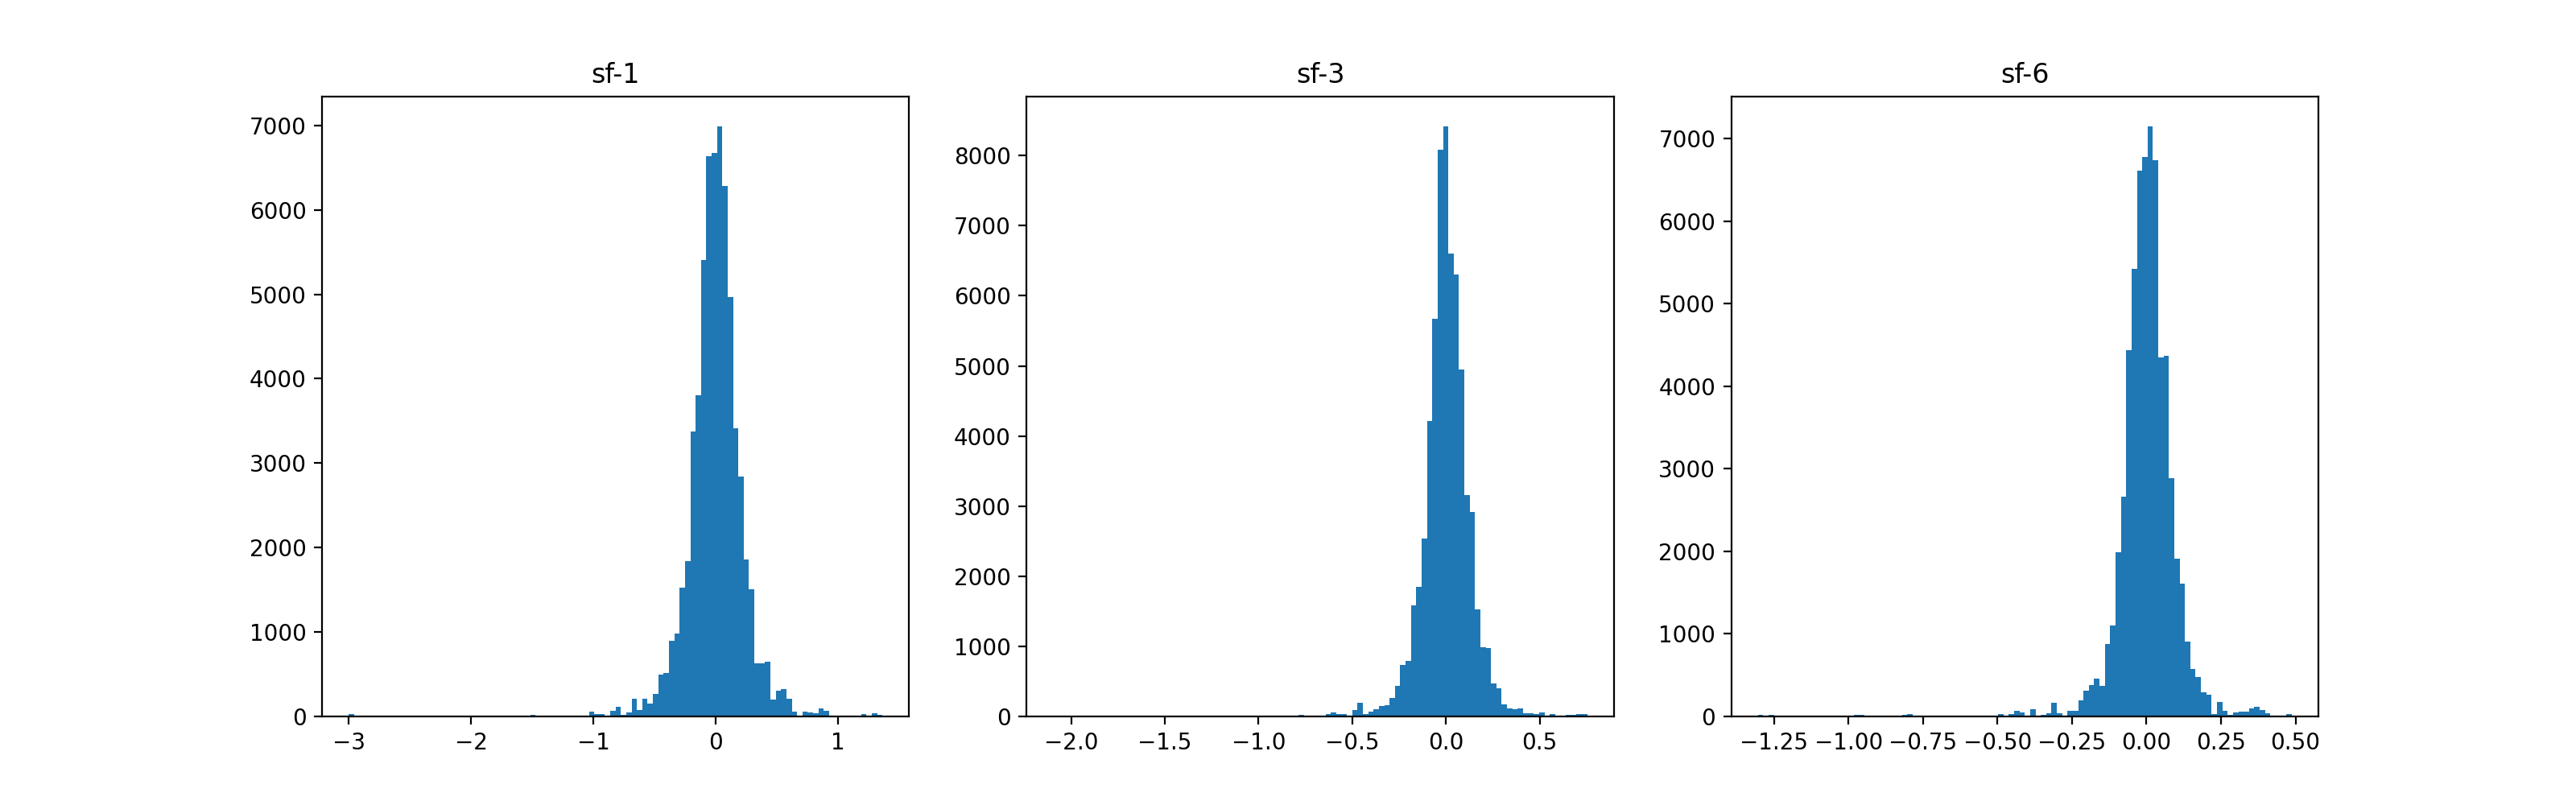

In [19]:
fig, ax = plt.subplots(figsize=(16,5), ncols=len(step_factor), nrows=1)

for sf_id in range(len(step_factor)):
    key_sf = f"sf-{step_factor[sf_id]}"
    values = results[key_sf]
    ax[sf_id].hist(values, bins=100)
    ax[sf_id].title.set_text(key_sf)

In [37]:
feature = Rates2D(context, step_factor=(1,2,3))

In [31]:
obs = feature.get()
obs

array([[-6.12807636e-04,  1.02689607e-03,  1.40421028e-03],
       [-3.18772413e-04,  1.86177620e-04,  7.31015649e-04],
       [-4.12531549e-04,  3.98346587e-04,  9.97257574e-04],
       [-8.33366489e-04, -6.06320611e-04,  1.00793954e-03],
       [-5.57884157e-04, -1.07470545e-03,  2.56900609e-04],
       [-4.56686566e-04, -4.65790025e-04, -2.71431545e-04],
       [-4.37657959e-04, -6.22949019e-04, -9.20739509e-04],
       [-3.45974671e-06, -5.07285362e-04, -5.21556817e-04],
       [-2.94078471e-06, -2.20558853e-04, -4.84076227e-04],
       [ 0.00000000e+00, -1.47039235e-06, -2.13351047e-06]])

In [38]:
obs = feature.get()
obs

array([[-6.12807636e-04,  1.02689607e-03,  1.40421028e-03],
       [-3.18772413e-04,  1.86177620e-04,  7.31015649e-04],
       [-4.12531549e-04,  3.98346587e-04,  9.97257574e-04],
       [-8.33366489e-04, -6.06320611e-04,  1.00793954e-03],
       [-5.57884157e-04, -1.07470545e-03,  2.56900609e-04],
       [-4.56686566e-04, -4.65790025e-04, -2.71431545e-04],
       [-4.37657959e-04, -6.22949019e-04, -9.20739509e-04],
       [-3.45974671e-06, -5.07285362e-04, -5.21556817e-04],
       [-2.94078471e-06, -2.20558853e-04, -4.84076227e-04],
       [ 0.00000000e+00, -1.47039235e-06, -2.13351047e-06]])

In [21]:
current_rate = dp.get_value("highest_bid")[0]
current_rate

23123.08

## sf=1

In [22]:
dp.data.loc[1675453069:1675453309, "highest_bid"]/current_rate - 1

Series([], Name: highest_bid, dtype: float64)

## sf=2

In [46]:
obs = feature.get()
obs

array([[-0.00126779, -0.01837254, -0.0223732 ],
       [-0.00129819, -0.01087517, -0.02477864],
       [-0.00110984, -0.00127643, -0.01257718],
       [-0.0011307 , -0.00120401, -0.00128369],
       [ 0.        , -0.00056535, -0.00074685]], dtype=float32)

In [29]:
dp.data.tail(10)

,dt,lowest_ask,highest_bid,asks,bids,buy_vol,sell_vol,total_vol,buy_num,sell_num,total_num
ts,,,,,,,,,,,
1675452769,2023-02-03 22:32:49,23373.021484,23372.439453,"{'23373.02': 0.00035, '23378.43': 0.000379, '2...","{'23372.44': 0.702901, '23372.43': 0.14, '2337...",0.023718,0.028416,0.052134,7,6,13
1675452829,2023-02-03 22:33:49,23396.960938,23383.640625,"{'23396.96': 0.355256, '23396.97': 0.002065, '...","{'23383.64': 0.674272, '23383.63': 0.001246, '...",0.015210,0.016324,0.031534,3,7,10
1675452889,2023-02-03 22:34:49,23409.289062,23399.189453,"{'23409.29': 0.373047, '23409.30': 0.002066, '...","{'23399.19': 0.14, '23399.18': 0.104425, '2339...",0.013877,0.021983,0.035860,3,4,7
1675452949,2023-02-03 22:35:49,23404.089844,23392.009766,"{'23404.09': 0.35958, '23404.10': 0.002056, '2...","{'23392.01': 0.669712, '23392.00': 0.14, '2339...",0.008706,0.019148,0.027854,3,3,6
1675453009,2023-02-03 22:36:49,23424.550781,23418.060547,"{'23424.55': 0.359278, '23424.56': 0.002097, '...","{'23418.06': 0.66927, '23418.05': 0.059953, '2...",0.036118,0.002416,0.038534,3,2,5
1675453069,2023-02-03 22:37:49,23424.910156,23418.101562,"{'23424.91': 0.359278, '23424.92': 0.002107, '...","{'23418.10': 0.669269, '23418.09': 0.14, '2341...",0.021893,0.000513,0.022406,3,1,4
1675453129,2023-02-03 22:38:49,23430.929688,23418.029297,"{'23430.93': 0.359625, '23430.94': 0.001289, '...","{'23418.03': 0.669271, '23418.02': 0.09179, '2...",0.012593,0.015364,0.027957,2,2,4
1675453189,2023-02-03 22:39:49,23424.380859,23418.470703,"{'23424.38': 0.001333, '23432.74': 0.002122, '...","{'23418.47': 0.815634, '23418.44': 0.14, '2341...",0.044688,0.008411,0.053099,9,4,13
1675453249,2023-02-03 22:40:49,23428.791016,23418.421875,"{'23428.79': 0.354612, '23428.80': 0.001272, '...","{'23418.42': 0.673928, '23418.41': 0.640521, '...",0.017010,0.033221,0.050231,7,8,15


In [41]:
avg = 23419.7459
avg/current_rate-1

-5.6547906749249144e-05

In [40]:
avg = 23418.25
avg/current_rate-1

-0.00012041774617344014

In [ ]:
p = 

In [16]:
step_factor = 3
s = dp.get_values("highest_bid", step_factor=step_factor)
s

array([23149.76 , 23164.309, 23152.58 , 23138.93 , 23139.19 , 23141.83 ,
       23142.059, 23141.91 , 23154.45 , 23145.51 , 23151.53 , 23142.12 ,
       23130.24 , 23124.53 , 23132.291, 23132.291, 23123.4  , 23094.72 ,
       23094.709, 23101.75 , 23108.91 , 23115.709, 23113.541, 23103.81 ,
       23110.18 , 23112.52 , 23112.96 , 23123.   , 23123.012, 23123.08 ])

In [18]:
s[step_factor-1::step_factor]

array([23152.58 , 23141.83 , 23154.45 , 23142.12 , 23132.291, 23094.72 ,
       23108.91 , 23103.81 , 23112.96 , 23123.08 ])

In [11]:
s

array([23151.53 , 23142.12 , 23130.24 , 23124.53 , 23132.291, 23132.291,
       23123.4  , 23094.72 , 23094.709, 23101.75 , 23108.91 , 23115.709,
       23113.541, 23103.81 , 23110.18 , 23112.52 , 23112.96 , 23123.   ,
       23123.012, 23123.08 ])